# Advanced Examples

## Making a Monte Carlo parameter study

In this example we will make a Monte Carlo study. This is case where the python library shows it's advangtage. 

We will make a Monte Carlo study on the position of patella tendon insertion and origin in the simplied knee model used in the first tutorial. Thus, we need some macros that  change two `sRel` variables in the model. In this case we choose the values from a uniform distribution, but any statisctical distribution could have been used. 

In [50]:
from scipy.stats import distributions

patella_tendon_insertion = distributions.norm([0.02, 0.12, 0], [0.01,0.01,0.01]) 
patella_tendon_origin = distributions.norm([0.0,-0.03, 0], [0.01,0.01,0.01]) 

In [6]:
from anypytools import macro_commands as mc, AnyMacro

mcr = AnyMacro(
        mc.SetValue_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ),
        mc.SetValue_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) 
       )

macro_list  = mcr.create_macros(100)

The first generated macro just have the default values.

In [7]:
macro_list[0]

[u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}"',
 u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"']

The next two macros have random offses. 

In [8]:
macro_list[1:4]

[[u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}"',
  u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"'],
 [u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}"',
  u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"'],
 [u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}"',
  u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"']]

Now let us expand the macro to also load and run the model. 

In [38]:
macros = AnyMacro(seed = 1)

# Add commands to the macro
macros.extend([
    mc.Load('Knee.any'),
    mc.SetValue_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) ,
    mc.SetValue_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) ,
    mc.OperationRun('Main.MyStudy.InverseDynamics'),
    mc.Dump('Main.MyStudy.Output.MaxMuscleActivity')
])

monte_carlo_macros = macros.create_macros_MonteCarlo(100)

The macro is passed to the AnyPyProcess object which excutes the macros

In [31]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
monte_carlo_results = app.start_macro( monte_carlo_macros )

[****************100%******************]  100 of 100 complete

The output object (`monte_carlo_result`) is list-like object where each element is dictionary of with the output of a simulation.

In [32]:
print('Length :', len(monte_carlo_results) )
print('Data keys in first element: ', monte_carlo_results[0].keys())

('Length :', 100)
('Data keys in first element: ', ['Main.MyStudy.Output.MaxMuscleActivity'])


Eventhough the object looks like a list, we can also data directly. This will return the data in a single matrix. In fact, we don't even have to use the full name of the variable. As long as it is uniquely defined in the data set.

In [48]:
monte_carlo_results['Main.MyStudy.Output.MaxMuscleActivity']
monte_carlo_results['MaxMus']

array([[ 0.00890538,  0.00927552,  0.00986515, ...,  0.00986515,
         0.00927552,  0.00890538],
       [ 0.00823531,  0.00857665,  0.00912038, ...,  0.00912038,
         0.00857664,  0.00823532],
       [ 0.00970935,  0.01010995,  0.01074553, ...,  0.01074553,
         0.01010994,  0.00970936],
       ..., 
       [ 0.01017174,  0.01059427,  0.01126661, ...,  0.01126661,
         0.01059427,  0.01017175],
       [ 0.01036841,  0.01079867,  0.0114824 , ...,  0.0114824 ,
         0.01079867,  0.01036841],
       [ 0.0098879 ,  0.01029588,  0.0109433 , ...,  0.0109433 ,
         0.01029587,  0.00988791]])

Now we can calculate the minimum and maximum muscle activity over all the trials

In [35]:
min_muscle_activity = monte_carlo_results['MaxMus'].min(axis=0)
max_muscle_activity = monte_carlo_results['MaxMus'].max(axis=0)

Finaly we can plot the result of the Monte Carlo study

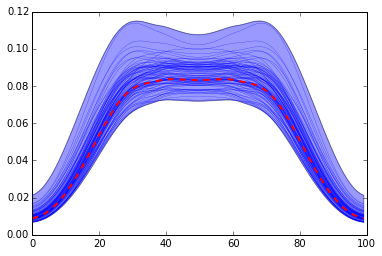

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range( monte_carlo_results['MaxMus'].shape[1] )
plt.fill_between(x, min_muscle_activity, max_muscle_activity,alpha=0.4  )
for trace in monte_carlo_results['MaxMus']:
    plt.plot( trace,'b', lw=0.2 )
# Plot the mean value that was stored in the first results
plt.plot(x, monte_carlo_results['MaxMus'][0],'r--', lw = 2, ) 


## Latin Hypercube sampling

Monte carlo studies are not very efficient when investigating the effect of many parameters. It quickly becomes necessary to run the model tens of thousands of times. Not very convienient if the AnyBody model takes a long time to run. 

An other approach is to use Latin Hypercube sampling. From wikipedia
> Latin hypercube sampling (LHS) is a statistical method for generating a sample of plausible collections of parameter values from a multidimensional distribution. The sampling method is often used to construct computer experiments.

Using LHS we can genrate a sample which better spans the whole multidimensional space. Thus, a lot fever model evaluations are necessary. See [pyDOE](http://pythonhosted.org/pyDOE/randomized.html) for examples (and explanation of the `criterion` parameter).

To following uses LHS to do the same as in the previous example:

In [44]:
patella_tendon_insertion = distributions.norm([0.02, 0.12, 0], [0.01,0.01,0.01]) 
patella_tendon_origin = distributions.norm([0.0,-0.03, 0], [0.01,0.01,0.01]) 

# Add commands to the macro
macros = AnyMacro(seed = 1)

# Add commands to the macro
macros.extend([
    mc.Load('Knee.any'),
    mc.SetValue_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) ,
    mc.SetValue_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) ,
    mc.OperationRun('Main.MyStudy.InverseDynamics'),
    mc.Dump('Main.MyStudy.Output.MaxMuscleActivity')
])

LHS_macros = macros.create_macros_LHS(100,criterion='cm')

In [45]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
lhs_results = app.start_macro(LHS_macros)

[****************100%******************]  100 of 100 complete

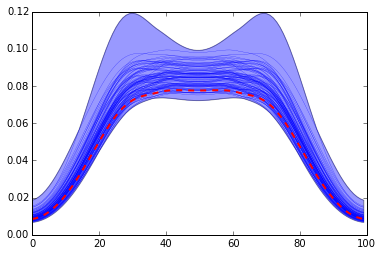

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range( lhs_results['MaxMus'].shape[1] )
plt.fill_between(x, lhs_results['MaxMus'].min(axis=0), lhs_results['MaxMus'].max(axis=0),alpha=0.4  )
for trace in lhs_results['MaxMus']:
    plt.plot( trace,'b', lw=0.2 )

plt.plot(x, lhs_results['MaxMus'][0],'r--', lw = 2, ) 

